In [1]:
import os

# check if in kaggle 
if 'KAGGLE_CONTAINER_NAME' in os.environ:
    kaggle = True
    os.chdir('/kaggle/working/NNDL-recoloring-GAN')
    print(os.getcwd())
    # pull repo to update .py files
    os.system('git pull')
    os.system('pip install torchview')
    os.system('pip install torchinfo')
    
else:
    kaggle = False
    

In [2]:
from dataset import CocoDataset
from train import Trainer, WTrainer
from models import Generator, Discriminator
from losses import GeneratorCriterion, DiscriminatorCriterion
from torchvision.transforms import Compose, ToTensor, Grayscale, Resize
from torch.utils.data import DataLoader
import torch
from torchsummary import summary
from torchview import draw_graph


# Dataset creation

In [3]:
if kaggle:
    DATASET_ROOT = '/kaggle/input/coco-2017-dataset/coco2017'
else:
    DATASET_ROOT = 'C:\\Users\\loren\\Datasets\\coco2017'

print(DATASET_ROOT)

C:\Users\loren\Datasets\coco2017


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define transformations to apply to each dataset input and output

In [5]:
transform_x_train = Compose([
    ToTensor(),
    Resize((256,256)), # TODO: to be tuned
    Grayscale() # TODO: think about other transformation / data augmentation techniques (be carefull that the transformation must be the same for x and y (eg. random ones, probably need to rewrite class)
])

transform_y_train = Compose([
    ToTensor(),
    Resize((256,256)) # TODO: to be tuned
])

# TODO: think if transformations for val and test have to be different from the train one
transform_x_val = transform_x_test = transform_x_train
transform_y_val = transform_y_test = transform_y_train

## Get dataset objects from helper function

In [6]:
train_dataset = CocoDataset(dataset_folder=DATASET_ROOT, dataset_type='train', transform_x=transform_x_train,
                            transform_y=transform_y_train, frac=0.01)

val_dataset = CocoDataset(dataset_folder=DATASET_ROOT, dataset_type='val', transform_x=transform_x_val,
                            transform_y=transform_y_val, frac=0.1)

test_dataset = CocoDataset(dataset_folder=DATASET_ROOT, dataset_type='test', transform_x=transform_x_test,
                            transform_y=transform_y_test, frac=0.1)
# TODO: Think about working in Lab colorspace and use just 2 vectors as output


## Define corresponding dataloaders

In [7]:
BATCH_SIZE = 8 # TODO: to be tuned
NUM_WORKERS = 4 # TODO: to be tuned

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
                              pin_memory=True, persistent_workers=True)

val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                            pin_memory=True, persistent_workers=True)

test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                             pin_memory=True, persistent_workers=True)



# Model Definition

### Generator

In [11]:
generator = Generator()
generator.to(device)
print(summary(generator, input_size=(1, 256, 256), batch_size=BATCH_SIZE))




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 256, 256]             576
       BatchNorm2d-2          [8, 64, 256, 256]             128
              ReLU-3          [8, 64, 256, 256]               0
            Conv2d-4          [8, 64, 256, 256]          36,864
       BatchNorm2d-5          [8, 64, 256, 256]             128
              ReLU-6          [8, 64, 256, 256]               0
         ConvBlock-7          [8, 64, 256, 256]               0
         MaxPool2d-8          [8, 64, 128, 128]               0
            Conv2d-9         [8, 128, 128, 128]          73,728
      BatchNorm2d-10         [8, 128, 128, 128]             256
             ReLU-11         [8, 128, 128, 128]               0
           Conv2d-12         [8, 128, 128, 128]         147,456
      BatchNorm2d-13         [8, 128, 128, 128]             256
             ReLU-14         [8, 128, 1

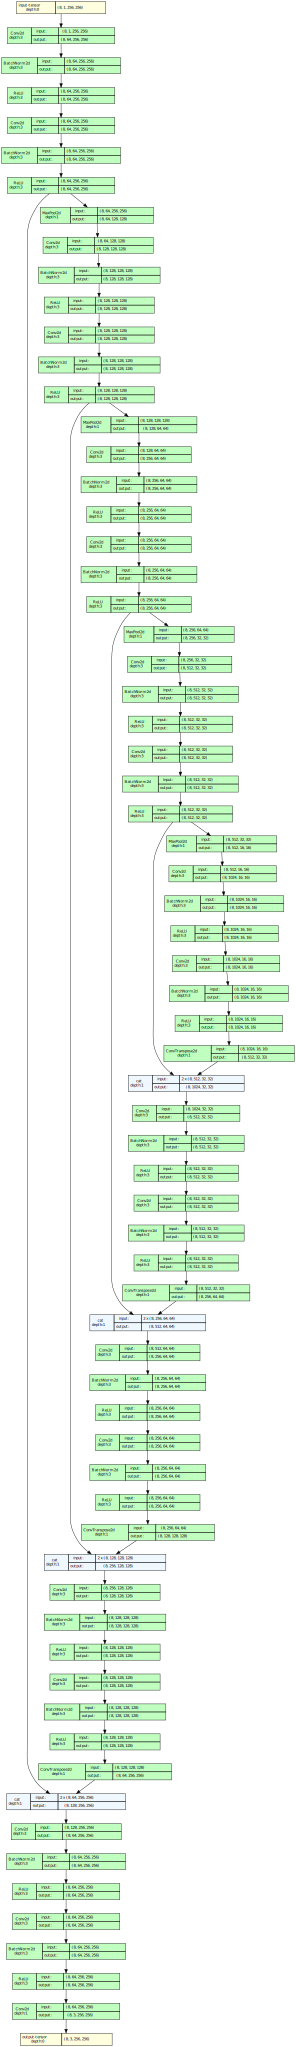

In [13]:
generator_graph = draw_graph(generator, input_size=(BATCH_SIZE, 1, 256, 256))
generator_graph.visual_graph

## Discriminator

In [16]:
discriminator = Discriminator()
discriminator.to(device)
print(summary(discriminator, input_size=(4, 256, 256), batch_size=BATCH_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 128, 128]           2,368
       BatchNorm2d-2          [8, 64, 128, 128]             128
         LeakyReLU-3          [8, 64, 128, 128]               0
            Conv2d-4           [8, 128, 64, 64]          73,856
       BatchNorm2d-5           [8, 128, 64, 64]             256
         LeakyReLU-6           [8, 128, 64, 64]               0
            Conv2d-7           [8, 256, 32, 32]         295,168
       BatchNorm2d-8           [8, 256, 32, 32]             512
         LeakyReLU-9           [8, 256, 32, 32]               0
           Conv2d-10           [8, 512, 31, 31]       2,097,664
      BatchNorm2d-11           [8, 512, 31, 31]           1,024
        LeakyReLU-12           [8, 512, 31, 31]               0
           Conv2d-13             [8, 1, 30, 30]           8,193
Total params: 2,479,169
Trainable param

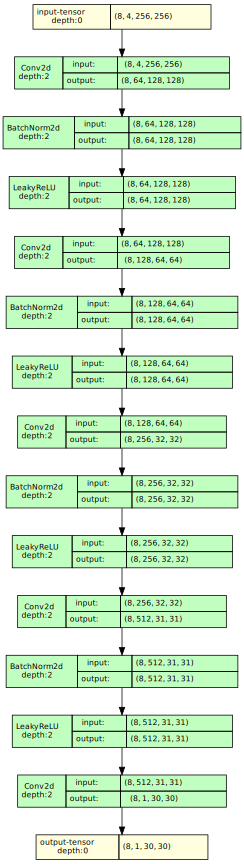

In [17]:
discriminator_graph = draw_graph(discriminator, input_size=(BATCH_SIZE, 4, 256, 256))
discriminator_graph.visual_graph

## Define Losses

In [10]:
disc_criterion = DiscriminatorCriterion(device=device, wgan=False, wgan_gp=False)

In [11]:
gen_criterion = GeneratorCriterion(device=device, use_l1_loss=True, l1_lambda=100, wgan=False)

## Define Optimizers

In [12]:
# gen_opt = torch.optim.RMSprop(generator.parameters(), lr=5e-5)
# disc_opt = torch.optim.RMSprop(discriminator.parameters(), lr=5e-5)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

# Training

In [13]:
options = {
    'checkpoint_path': './test.tar',
    'reset_training': True,
    'num_epochs': 10,
    'clip_weights': False,
    'n_critic': 5
}

In [14]:
# GAN Trainer
trainer = Trainer(generator=generator, discriminator=discriminator,
                  gen_optimizer=gen_opt, disc_optimizer=disc_opt,
                  gen_scheduler=None, disc_scheduler=None,
                  gen_criterion=gen_criterion, disc_criterion=disc_criterion,
                  train_loader=train_dataloader, val_loader=val_dataloader,
                  device=device, options=options)

# WGAN trainer
# trainer = WTrainer(generator=generator, discriminator=discriminator,
#                   gen_optimizer=gen_opt, disc_optimizer=disc_opt,
#                   gen_scheduler=None, disc_scheduler=None,
#                   gen_criterion=gen_criterion, disc_criterion=disc_criterion,
#                   train_loader=train_dataloader, val_loader=val_dataloader,
#                   device=device, options=options)

No checkpoint found at ./test.tar
Starting from scratch


In [15]:
trainer.train()




Epoch 1/10
Training...


  3%|▎         | 4/148 [00:12<07:21,  3.07s/it]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
gray, color = train_dataset[0]

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
plt.imshow(gray.permute(1,2,0), cmap='gray')

In [ ]:
plt.imshow(color.permute(1, 2, 0))

In [ ]:
generated = generator(gray.unsqueeze(dim=0).to(device))
generated = generated.detach().cpu().squeeze()

In [ ]:
plt.imshow(generated.permute(1, 2, 0))

In [ ]:
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['train_gen_loss'])
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['train_disc_loss'])